# Linking CO and KO
housecleaning: pull out the pieces that can go somewhere else to get a 
clean version of the iPython notebook
4/12/2016 ; 4/15/2016

#Cell 14 is the place to change the path for the transcriptomics data...too big for GitHub

KL to do list: see B18/p94: make the plots not repeat isomers for the KEGG compounds, but present # of isomers

In [3]:
#%reset

In [240]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.cluster import KMeans
import cPickle as cpk
from IPython.core.debugger import Tracer 

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio.KEGG.REST import *

%matplotlib inline

In [5]:
#corrected bug in MATLAB code that resulted in duplicate row numbers
mtabFile = 'RImetabolites_isomers.2016.09.01.csv' #first column is RInumber

In [6]:
CO_fromMATLAB=pd.read_csv(mtabFile, index_col='RInumber')

In [7]:
#make a list of the unique CO numbers for the CreateHash_COtoKO.py. Export the list as CSV
td = CO_fromMATLAB.groupby('cNumber').count()
COnumbers = td.drop(list(td.columns.values),axis=1)
del td
COnumbers.to_csv('exportCOnumbers.csv',header=True)

###Write a couple of functions to swap between CO and RInumbers

In [8]:
def findRInumber(dataIn,KEGGin):
    #find possible RI numbers for a given KEGG number. 
    dataOut = []
    for i,KEGG in enumerate(dataIn['KEGG']):
        if KEGG == KEGGin:
            t = dataIn.index[i]
            dataOut.append(t)
    return dataOut
##For example: this will give back one row, C18028 will be multiple
#m = findRInumber(forRelatedness,'C00078') 

def convertRItoCO(dataIn,RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = dataIn.loc[RIin].loc['cNumber']
    return dataOut
##This will always be a single value
#m = convertRItoCO(forRelatedness,'RI2')

#slight change, no need to send in a comparison file if it always the same thing
def convertRItoCO2(RIin):
    #do the reverse, given an RInumber find the cNumber
    dataOut = CO_fromMATLAB.loc[RIin].loc['cNumber']
    return dataOut
##This will always be a single value, also uses CO_fromMATLAB as input 

In [9]:
#This grabs the CO/KO links from the KEGG website. The actual code is in the 
#CreateHash_COtoKO.py that Harriet wrote. Note that since the exportCOnumbers.csv 
#file is a unique list of C number we essentially already have a lookup table 
#for all the metabolites of interest.

if os.path.isfile('exportCOnumbers.csv' + '.pickle'):
    #just read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))
else:
    #need to make the file
    filename = "CreateHash_COtoKO.py"
    %run $filename exportCOnumbers.csv 
    #then read in the file
    WorkingFile = cpk.load(open('exportCOnumbers.csv.pickle','r'))

In [10]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'

There are 404 COs with an associated KO. 1438 are not associated with a KO.


In [11]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

In [12]:
#go through CO_RawData_all one row at a time (inefficient for sure, but I understand 
#what is happening), then make a new column in CO_RawData_all that is True/False
CO_fromMATLAB['inList'] = ""

for idx in range(0,len(CO_fromMATLAB)):
# for idx in range(0):
    fc = CO_fromMATLAB.ix[idx,'cNumber']
    if fc in AllCO:
        CO_fromMATLAB.ix[idx,'inList'] = True
    else:
        CO_fromMATLAB.ix[idx,'inList'] = False  

In [13]:
#can't quite figure out how to do this in one step.
m = CO_fromMATLAB[CO_fromMATLAB['inList']==True]
CO_metadata_pruned = m.loc[:,['cNumber','ChargedMass','RT','ionMode']]

#this list of days is useful, so define it up front.
dayList = ['S1','S2','S3','S4','S5'] 
CO_RawData_pruned = m.loc[:,dayList]
del m

In [14]:
#Load PhytoKEGG Annotations
#from Harriet...doesn't work, complaining about header=False 
#AllPhytoKO_ann=pd.read_table('AllPhytoKegg_annotated.tab', header=False, delimiter='\t')

#try this instead (note double \\ at end)
#pathToData = 'Z:\KLtemp\TranscriptomicsData_Feb2016\\'
pathToData = 'C:\Users\Krista\Documents\Current projects\Kujawinski_Metabolomics_RIsamples\TranscriptomicsData_Feb2016\\'
AllPhytoKO_ann=pd.read_table((pathToData + 'AllPhytoKegg_annotated.tab'), delimiter='\t')

InsituCounts=pd.read_table((pathToData + 'AllInsitu_NoZero.tab'), index_col='gID')

In [15]:
#normalize to the library size
InsituTPM=InsituCounts.copy()
InsituTPM[['S1', 'S2', 'S3', 'S4', 'S5']]=(InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']]/InsituCounts[['S1', 'S2', 'S3', 'S4', 'S5']].sum())*10**6

#Add annotation information
InsituCounts=InsituCounts.join(AllPhytoKO_ann)
InsituTPM=InsituTPM.join(AllPhytoKO_ann)
InsituCounts=InsituCounts.dropna()
InsituTPM=InsituTPM.dropna()

KO_RawData=InsituTPM.groupby('kID').sum()

In [16]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out

def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

In [17]:
#norm2Mean seems based (see plots in earlier notebooks)
KO_Norm2Mean=NormalizeToMean(KO_RawData) 

##two versions of the CO data: (1) regular and (2) inverse
CO_Norm2Mean_regular=NormalizeToMean(CO_RawData_pruned) 
CO_Norm2Mean_inverse=NormalizeToMean(1/CO_RawData_pruned)

In [18]:
#use _finalOption variable names to make life easier
KO_finalOption = KO_Norm2Mean.loc[AllKO].dropna()
CO_final_regular = CO_Norm2Mean_regular.dropna() #already 'limited' this before the normalization
CO_final_inverse = CO_Norm2Mean_inverse.dropna() #already 'limited' this before the normalization

In [19]:
##Combine the CO and the KO data in preparation for K means clustering
Combined_KO_CO_regular=KO_finalOption.append(CO_final_regular.loc[:,(dayList)])
Combined_KO_CO_inverse=KO_finalOption.append(CO_final_inverse.loc[:,(dayList)])

In [20]:
def kmeanCluster(data,nc):
    #kmeans=KMeans(n_clusters=nc)
    kmeans = KMeans(n_clusters = nc, max_iter = 1000, n_init = 50, init = 'random')
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
    
def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Move forward with 'best' number of clusters
--> use Determine_Optimal_Number_Kmeans_Groups.ipynb to determine this number

In [21]:
#setting # of clusters manually, also some good options with lower # of clusters I think
#this number will get used later when plotting up the BRITE categories and the Kmeans clusters
makeNclusters = 6

In [22]:
#do the K-means clustering with the final # of clusters
CcoClust_regular=kmeanCluster(Combined_KO_CO_regular, makeNclusters) 
CcoClust_inverse=kmeanCluster(Combined_KO_CO_inverse, makeNclusters) 

In [23]:
#import matplotlib as mpl
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=2, figSizeY=3, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k',range = (0,kSize),align = 'left')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    #Cs=re.compile('C.*')
    Cs = re.compile('R.*') #this is the RInumber I created...for the moment, do not need the Cnumber
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='b')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='r')
        SumKC=len(KData.T)+len(CData.T)
        KPct=(len(KData.T))
        CPct=(len(CData.T))
        ax.set_title('nGenes ' + str(KPct) + ', nCpds ' + str(CPct) + ', Cluster ' + str(y))
        ax.set_ylim([0,5])
    return fig
    #fig.savefig(figureName)

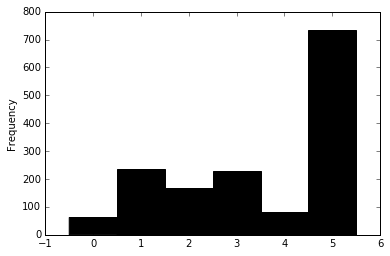

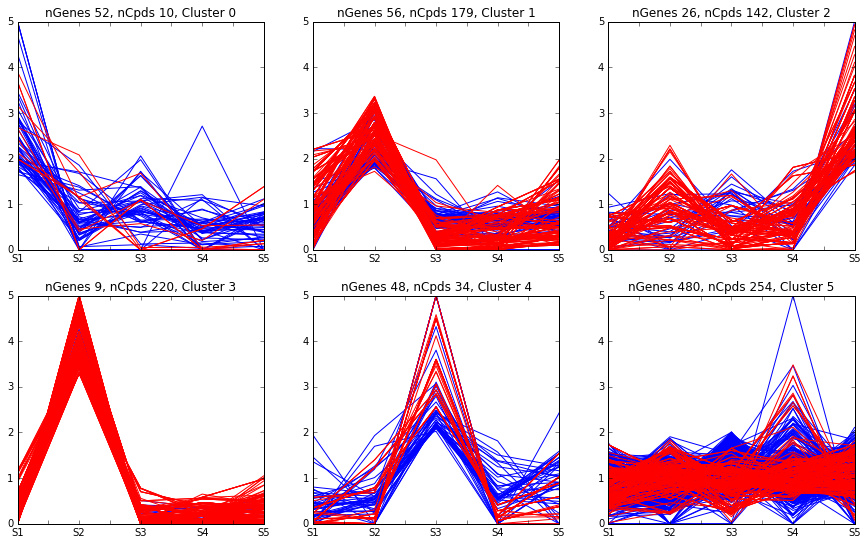

In [24]:
f = PlotKmeansCombined(CcoClust_regular,makeNclusters) 
f.savefig('Kmeans_regular.png')
del f

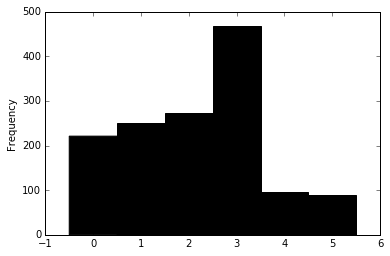

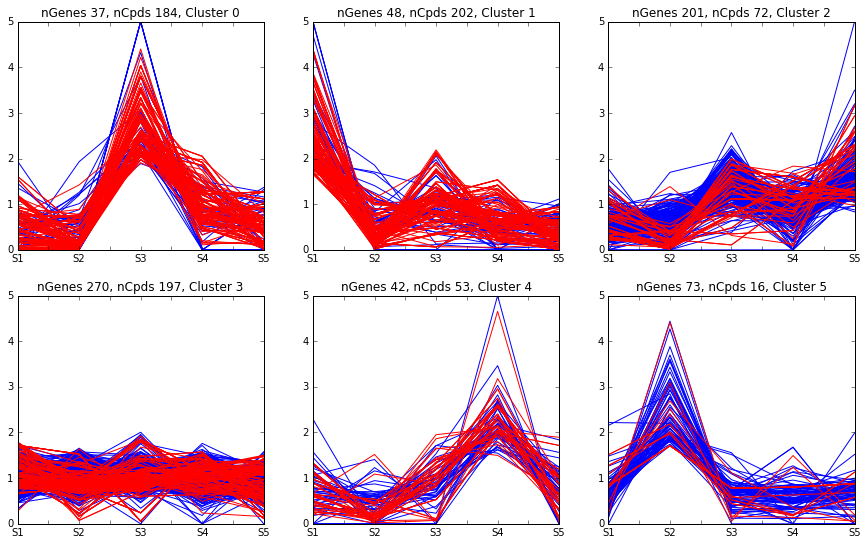

In [25]:
f = PlotKmeansCombined(CcoClust_inverse,makeNclusters) 
f.savefig('Kmeans_inverse.png')
del f

If only doing species plots...still need the next cell

In [26]:
#need this cell to get the taxonomic information used in the species plots later on

#load in the species/group information
Group_Species=pd.read_table('GrpSpecies',delimiter=' ').T.drop(['MMETSP', 
                                                  'MMETSP.1']).T.drop_duplicates().set_index('SName')

InsituTPMGrped=InsituTPM.groupby(['kID','sgID']).sum().reset_index().set_index('sgID')

Group_Species=Group_Species.reset_index()
#get the specific group combos
Dia=Group_Species[Group_Species['Grp']=='Bacillariophyta']
Din=Group_Species[Group_Species['Grp']=='Dinophyta']
Oth=Group_Species[((Group_Species['Grp']!='Dinophyta')&
                  (Group_Species['Grp']!='Bacillariophyta'))]
#get the insitu counts
Insitu_TPM_DIA=InsituTPMGrped.loc[Dia['SName']].groupby('kID').sum()
Insitu_TPM_DIN=InsituTPMGrped.loc[Din['SName']].groupby('kID').sum()
Insitu_TPM_Oth=InsituTPMGrped.loc[Oth['SName'].dropna()].groupby('kID').sum()

D=set(Insitu_TPM_DIA.index)
N=set(Insitu_TPM_DIN.index)
O=set(Insitu_TPM_Oth.index)

C:\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


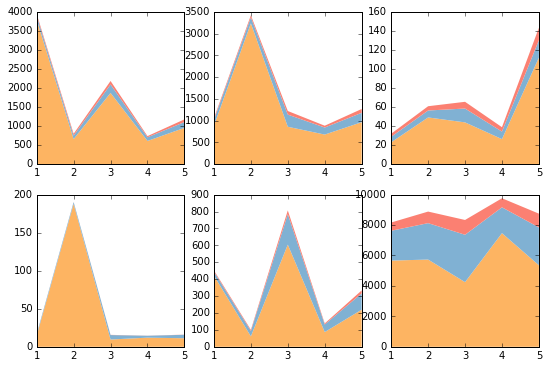

In [27]:
fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust_regular['kmeans']):
    ClusterK = CcoClust_regular[CcoClust_regular['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)

    Dsum=Insitu_TPM_DIA.loc[Di].sum()
    Nsum=Insitu_TPM_DIN.loc[Ni].sum()
    Osum=Insitu_TPM_Oth.loc[Di].sum()

    ax=axs[i]
    ax.stackplot(range(5), Dsum, Nsum, Osum, colors=
                 pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
    ax.set_xticks(range(5))
    ax.set_xticklabels([1,2,3,4,5])

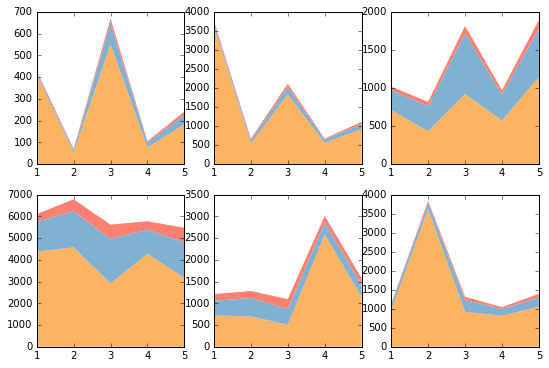

In [28]:
fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust_inverse['kmeans']):
    ClusterK = CcoClust_inverse[CcoClust_inverse['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)

    Dsum=Insitu_TPM_DIA.loc[Di].sum()
    Nsum=Insitu_TPM_DIN.loc[Ni].sum()
    Osum=Insitu_TPM_Oth.loc[Di].sum()

    ax=axs[i]
    ax.stackplot(range(5), Dsum, Nsum, Osum, colors=
                 pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
    ax.set_xticks(range(5))
    ax.set_xticklabels([1,2,3,4,5])

###focus on things with common linked reactions...

In [29]:
#But...for the CheckRelatedness...do need to go back to the cNumber...
#for now, easiest to just make yet another matrix and put the cNumbers back in.
forRelatedness_regular = CcoClust_regular.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness_regular.insert(0,'KEGG',"") #add a column called 'KEGG'

forRelatedness_inverse = CcoClust_inverse.copy(deep=True) #make a copy of the CcoClust data frame
forRelatedness_inverse.insert(0,'KEGG',"") #add a column called 'KEGG'

In [30]:
for idx in range(0,len(forRelatedness_regular)):
    t = forRelatedness_regular.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness_regular.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness_regular.ix[idx,('KEGG')] = t
        
for idx in range(0,len(forRelatedness_inverse)):
    t = forRelatedness_inverse.iloc[idx,:].name

    if t[0]=='R':
        #go find the matching cNumber in CO_RawData_all
        t2 = CO_fromMATLAB.loc[t,('cNumber')]
        forRelatedness_inverse.ix[idx,('KEGG')] = t2
    elif t[0] == 'K':
        #just copy the K number over
        forRelatedness_inverse.ix[idx,('KEGG')] = t

In [31]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        #i=kClust.index
        i = kClust.KEGG #change the new column I created with Cnumbers and Knumbers
        i=list(i)
        Csearc=re.compile('C.*') #re is regular expression...perl-like 
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)

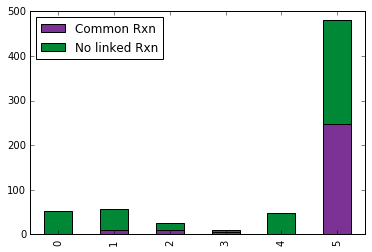

In [32]:
CheckRelatedness(forRelatedness_regular, makeNclusters)

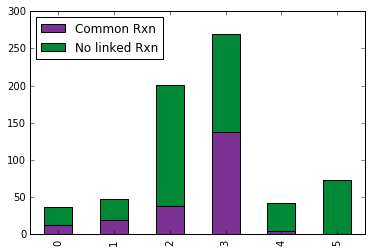

In [33]:
CheckRelatedness(forRelatedness_inverse, makeNclusters)

Grab the information from KEGG for plotting and bean counting

In [34]:
allPathways = kegg_list("pathway").read()
len(allPathways.split('\n'))
#number here is the # of pathways at KEGG, up to 486 by 4/13/2016

496

In [35]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
    tp = line[8:13]
    trimPath.append('ko' + tp)
    
#have some cases where KEGG will send back a pathway, but the pathway itself is not searchable...seems to 
#be a KEGG bug, 'ko00351' was first, then realized there are many of these,
#did this list manually since I thought it would be short...
toDelete = ('ko00351', 'ko01010','ko01060',  'ko01061', 'ko01062', 'ko01063', 
            'ko01064', 'ko01065', 'ko01066', 'ko01070', 'ko07011', 'ko07012', 
            'ko07013', 'ko07014', 'ko07015', 'ko07016', 'ko07017', 'ko07018', 
            'ko07019', 'ko07020', 'ko07021', 'ko07023', 'ko07024', 'ko07025', 
            'ko07026', 'ko07027', 'ko07028', 'ko07029', 'ko07030', 'ko07031', 
            'ko07032', 'ko07033', 'ko07034', 'ko07035', 'ko07036', 'ko07037', 
            'ko07038', 'ko07039', 'ko07040', 'ko07041', 'ko07042', 'ko07043', 
            'ko07044', 'ko07045', 'ko07046', 'ko07047', 'ko07048', 'ko07049', 
            'ko07050', 'ko07051', 'ko07052', 'ko07053', 'ko07054', 'ko07055', 
            'ko07056', 'ko07057', 'ko07110', 'ko07112', 'ko07114', 'ko07117', 
            'ko07211', 'ko07212', 'ko07213', 'ko07214', 'ko07215', 'ko07216', 
            'ko07217', 'ko07218', 'ko07219', 'ko07220', 'ko07221', 'ko07222', 
            'ko07223', 'ko07224', 'ko07225', 'ko07226', 'ko07227', 'ko07228', 
            'ko07229', 'ko07230', 'ko07231', 'ko07232', 'ko07233', 'ko07234', 
            'ko07235', 'ko04933')

#probably a way to do this without the for loop, but this will work
for item in toDelete:
    trimPath.remove(item)

In [36]:
shortList = ['ko03010','ko03013','ko00140'] #for testing

In [37]:
import fxn_gatherDetails
##if I make a change, have to reload the function:
#reload(fxn_gatherDetails)

In [38]:
#usePathway = shortList #for testing...use complete list later
usePathway = trimPath
KOandCOwithKmeans = forRelatedness_regular #linked KO & CO, data, with K means information
useCO = CO_fromMATLAB #full list of CO data, need to color pathway, and lookup table
useKO = KO_Norm2Mean # full list of KO data, need to color pathway
dia = Insitu_TPM_DIA #diatom TPM, for plotting species
din = Insitu_TPM_DIN #dino TPM, for plotting species
oth = Insitu_TPM_Oth #other TPM, for plotting species

In [39]:
if False: 
    folder = 'plots_regular_Km'
    gc_regular = fxn_gatherDetails.gatherDetails(makeNclusters,usePathway,KOandCOwithKmeans,folder,useCO,useKO,dia,din,oth)
    #now...save all that so I don't have to do this everytime BUT be careful with re-assigning K means group numbers!
    cpk.dump(gc_regular, open('gatherCounts_norm2mean_regular.2016.09.01.pickle', 'wb'))

In [40]:
if False:
    #switch to inverse, repeat 
    KOandCOwithKmeans = forRelatedness_inverse #linked KO & CO, data, with K means information
    folder = 'plots_inverse_Km'

    gc_inverse = fxn_gatherDetails.gatherDetails(makeNclusters,usePathway,KOandCOwithKmeans,folder,useCO,useKO,dia,din,oth)
    cpk.dump(gc_inverse, open('gatherCounts_norm2mean_inverse.2016.09.01.pickle', 'wb'))

In [41]:
## this is the code to read in the file...can use this without having to go through the pain of rerunning gatherCounts
gatherCounts_regular = cpk.load(open('gatherCounts_norm2mean_regular.2016.09.01.pickle','rb'))
gatherCounts_inverse = cpk.load(open('gatherCounts_norm2mean_inverse.2016.09.01.pickle','rb'))

In [42]:
def plotGenes_ratio(tg):
    #if this is something in the pathway, plot up the species for the K number
    if (tg in Insitu_TPM_DIA.index.tolist()) and (tg in Insitu_TPM_DIN.index.tolist()):
        DaDn=Insitu_TPM_DIA.loc[tg]/Insitu_TPM_DIN.loc[tg]

    if (tg in Insitu_TPM_DIA.index.tolist()) and (tg in Insitu_TPM_Oth.index.tolist()):
        DaOt=Insitu_TPM_DIA.loc[tg]/Insitu_TPM_Oth.loc[tg]

    if (tg in Insitu_TPM_DIN.index.tolist()) and (tg in Insitu_TPM_Oth.index.tolist()):
        DnOt=Insitu_TPM_DIN.loc[tg]/Insitu_TPM_Oth.loc[tg]

    useColors = pal.colorbrewer.qualitative.Set1_3.hex_colors    
    ms = 200 #set the size of the dots
    fig,axs=plt.subplots(1,3)
    fig.set_size_inches(10,4)
    axs[0].scatter(range(5),DaDn,s = ms, color = useColors[0])
    axs[0].set_title('DIA:DIN')
    axs[0].set_xticks(range(5))
    axs[0].set_ylabel('Ratios')

    axs[1].scatter(range(5),DaOt,s = ms, color = useColors[1])
    axs[1].set_title('DIA:Oth')
    axs[1].set_xticks(range(5))

    axs[2].scatter(range(5),DnOt,s = ms, color = useColors[2])
    axs[2].set_title('DIN:Oth')
    axs[2].set_xticks(range(5))

    #fig.savefig(directorySpecies + '/' + tg + '_species.png',bbox_inches='tight')
    #plt.close()

In [43]:
#make a function to calculate the ratios of the three TPM groups
#function expects a version of the forRelatedness_XXXX dataframe:
def calcTPMratios(dataIn):

    #do NOT pull the KEGG numbers bc that causes issues downstream with the plotting: confusion of numbers/text
    df2 = dataIn.loc[:,('kmeans')]
    
    df2 = df2.to_frame() #this gets around the error about working on a copy of a slice
    df2['inList'] = ''

    for idx in range(0,len(df2)):
        fc = df2.index.values[idx]

        if fc[0] == 'C':
            df2.ix[idx,'inList'] = False
        elif fc[0] == 'K':
            df2.ix[idx,'inList'] = True  

    df2 = df2[df2['inList']==True]
    df2 = df2.T.drop('inList').T #this somehow gets around the warning about making a change on a copy...?

    for tg,row in df2.iterrows():

        if (tg in Insitu_TPM_DIA.index.tolist()) and (tg in Insitu_TPM_DIN.index.tolist()):
            #use this to get the mean, ignoring any inf/NaN values
            tv = Insitu_TPM_DIA.loc[tg,:]/Insitu_TPM_DIN.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanDaDn'] = t 
        else:
            df2.loc[tg,'meanDaDn'] = np.nan

        if (tg in Insitu_TPM_DIA.index.tolist()) and (tg in Insitu_TPM_Oth.index.tolist()):
            tv =  Insitu_TPM_DIA.loc[tg,:]/Insitu_TPM_Oth.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanDaOt'] = t
        else:
            df2.loc[tg,'meanDaOt'] = np.nan

        if (tg in Insitu_TPM_DIN.index.tolist()) and (tg in Insitu_TPM_Oth.index.tolist()):
            tv = Insitu_TPM_DIN.loc[tg,:]/Insitu_TPM_Oth.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanDnOt'] = t
        else:
            df2.loc[tg,'meanDnOt'] = np.nan
            
    return df2

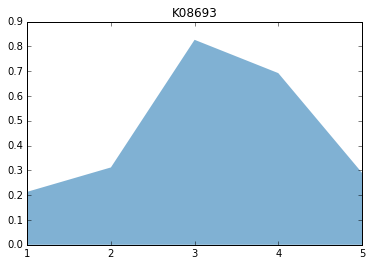

In [44]:
#explore...plot one gene here rather than digging it up from the folders
#this is the cell to make Liz's species plots
kid='K08693'
allK=InsituTPMGrped[InsituTPMGrped['kID']==kid].sum()
allK=allK.drop('kID')
allK=allK.astype('float')
allK

if kid in Insitu_TPM_DIA.index.tolist():
    Dk=Insitu_TPM_DIA.loc[kid]
else: 
    Dk = 0/allK

if kid in Insitu_TPM_DIN.index.tolist():
    Nk=Insitu_TPM_DIN.loc[kid]
else:
    Nk = 0/allK
    
if kid in Insitu_TPM_Oth.index.tolist():
    Ok=Insitu_TPM_Oth.loc[kid]
else:
    Ok = 0/allK
    
fig,ax=plt.subplots(1)
ax.stackplot(range(5), Dk, Nk, Ok, colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
ax.set_xticks(range(5))
ax.set_xticklabels([1,2,3,4,5])
plt.title(kid)
# ax.set_ylim(0,1)
fig.savefig(kid +'_gene_forLiz.pdf')

#there are very small values here for DIN and other, but can't see them on the figure

In [45]:
#function expects a version of the forRelatedness_XXXX dataframe:
def averageTPM(dataIn):

    #do NOT pull the KEGG numbers bc that causes issues downstream with the plotting: confusion of numbers/text
    df2 = dataIn.loc[:,('kmeans')]
    
    df2 = df2.to_frame() #this gets around the error about working on a copy of a slice
    df2['inList'] = ''

    for idx in range(0,len(df2)):
        fc = df2.index.values[idx]
        if fc[0] == 'C':
            df2.ix[idx,'inList'] = False
        elif fc[0] == 'K':
            df2.ix[idx,'inList'] = True  

    df2 = df2[df2['inList']==True]
    df2 = df2.T.drop('inList').T #this somehow gets around the warning about making a change on a copy...?

    for tg,row in df2.iterrows():

        if (tg in Insitu_TPM_DIA.index.tolist()) :
            #use this to get the mean, ignoring any inf/NaN values
            tv = Insitu_TPM_DIA.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanDia'] = t 
        else:
            df2.loc[tg,'meanDia'] = np.nan

        if (tg in Insitu_TPM_DIN.index.tolist()) :
            tv =  Insitu_TPM_DIN.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanDin'] = t
        else:
            df2.loc[tg,'meanDin'] = np.nan

        if (tg in Insitu_TPM_Oth.index.tolist()):
            tv = Insitu_TPM_Oth.loc[tg,:]
            t = np.ma.masked_invalid(tv).mean()
            df2.loc[tg,'meanOth'] = t
        else:
            df2.loc[tg,'meanOth'] = np.nan
            
    return df2

Consider diversity of other EC/genes (lots of examples follow)

In [46]:
def plotOneGene(kid):#explore...plot one gene here rather than digging it up from the folders
    #kid='K03183'
    allK=InsituTPMGrped[InsituTPMGrped['kID']==kid].sum()
    allK=allK.drop('kID')
    allK=allK.astype('float')
    allK

    if kid in Insitu_TPM_DIA.index.tolist():
        Dk=Insitu_TPM_DIA.loc[kid]
    else: 
        Dk = 0/allK

    if kid in Insitu_TPM_DIN.index.tolist():
        Nk=Insitu_TPM_DIN.loc[kid]
    else:
        Nk = 0/allK

    if kid in Insitu_TPM_Oth.index.tolist():
        Ok=Insitu_TPM_Oth.loc[kid]
    else:
        Ok = 0/allK
        
    #try not to plot things that are all NaN (though this will allow 'zeros', and
    #definitely have cases with 0 and NaN for a given gene)    
    if not Dk.dropna().empty and not Nk.dropna().empty and not Ok.dropna().empty: #only plot with data!
        fig,ax=plt.subplots(1)
        ax.stackplot(range(5), Dk, Nk, Ok, colors=pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
        ax.set_xticks(range(5))
        ax.set_xticklabels([1,2,3,4,5])
        fig.set_size_inches(2,2) #this is a property of the figure, not the axis...
        plt.title(kid)
        # ax.set_ylim(0,1)
        #fig.savefig(kid +'_numbers_forTalk.pdf')

In [47]:
#given a gene, go get all possible EC numbers, use them to search for other genes with that EC, and plot
#this will skip over genes that are not in the RI data
def plotMultipleEC(kid):
    getOne = kegg_list(kid).read()
    geneList = []

    for line in getOne.rstrip().split('\n'):
        r1 = line.find("[EC:")
        r2 = line.find("]")
        r = line[(r1+4):r2]
        r3 = r.split(' ')
        #now that I have the EC numbers...get the genes for each one
        for idx in r3:
            getK = kegg_link('ko',idx).read()
            for line3 in re.split('\n',getK):
                if line3 is not '':
                    ge = line3.find('ko')
                    t = line3[ge+3:]
                    geneList.append(t)
    geneList = set(geneList) #this will make the list of unique genes...can print that up

    for idx in geneList:
        plotOneGene(idx) #plotting function has already been defined above...

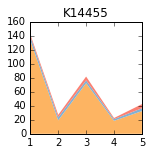

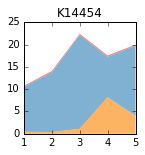

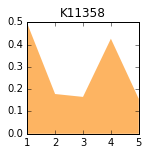

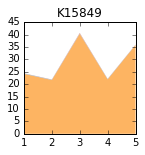

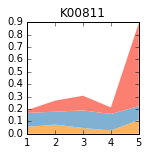

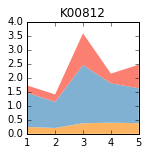

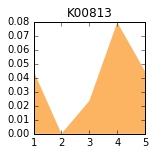

In [48]:
#in some cases, only get back the one gene we started with
plotMultipleEC('K00811')

In [ ]:
###latest request...figure out which pathways are overrepresented one group (i.e. more dino
#TPM than average...)

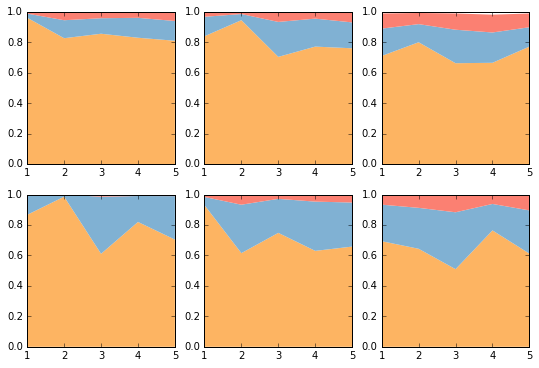

In [52]:
#dug up the following from GitHub, answer part of the latest question

fig, axs=plt.subplots(2,3)
fig.set_size_inches(9,6)
axs=axs.flatten()
for i in set(CcoClust_regular['kmeans']):
    ClusterK = CcoClust_regular[CcoClust_regular['kmeans']==i]
    ClusterKind=set([k for k in ClusterK.index if k.startswith('K')])

    Di=D.intersection(ClusterKind)
    Ni=N.intersection(ClusterKind)
    Oi=O.intersection(ClusterKind)
    
    Ksum=KO_RawData.loc[ClusterKind].sum()

    Dsum=Insitu_TPM_DIA.loc[Di].sum()/Ksum
    Nsum=Insitu_TPM_DIN.loc[Ni].sum()/Ksum
    Osum=Insitu_TPM_Oth.loc[Di].sum()/Ksum

    
    ax=axs[i]
    ax.stackplot(range(5), Dsum, Nsum, Osum, colors=
                 pal.colorbrewer.qualitative.Set3_6_r.hex_colors, lw=0)
    ax.set_xticks(range(5))
    ax.set_xticklabels([1,2,3,4,5])
    ax.set_ylim(0,1)

    #fig.savefig('ClusterPercentTPM.pdf')

First do calculation for all the genes, get mean proportion for a given gene

In [175]:
gatherAnswers = pd.DataFrame(index = KO_RawData.index.copy(),columns = ['meanDIA','meanDIN','meanOth'])

for idx in range(0,len(gatherAnswers)):
    kid = gatherAnswers.index.values[idx]
    allK=InsituTPMGrped[InsituTPMGrped['kID']==kid].sum()
    allK=allK.drop('kID')
    allK=allK.astype('float')

    if kid in Insitu_TPM_DIA.index.tolist():
        Dk=Insitu_TPM_DIA.loc[kid]/allK
    else: 
        Dk = 0/allK

    if kid in Insitu_TPM_DIN.index.tolist():
        Nk=Insitu_TPM_DIN.loc[kid]/allK
    else:
        Nk = 0/allK

    if kid in Insitu_TPM_Oth.index.tolist():
        Ok=Insitu_TPM_Oth.loc[kid]/allK
    else:
        Ok = 0/allK

    gatherAnswers.loc[kid,'meanDIA'] = Dk.mean()
    gatherAnswers.loc[kid,'meanDIN'] = Nk.mean()
    gatherAnswers.loc[kid,'meanOth'] = Ok.mean()


In [ ]:
#now use the means...

In [251]:
#start with one pathway

onePathway = pd.DataFrame(np.nan,index = range(0),columns = ['meanDIA','meanDIN','meanOth'])

item = 'ko00960'

geneList = kegg_link('ko',item).read() #get the genes in that pathway

for idx in range(0,len(geneList.splitlines())):
    t = geneList.splitlines()[idx] #start with the first row...
    oneK = t.split('\tko:')[1].rstrip()

    if oneK in gatherAnswers.index.tolist(): #have cases where we did not see the gene
        onePathway.loc[oneK,'meanDIA'] = gatherAnswers.loc[oneK,'meanDIA']
        onePathway.loc[oneK,'meanDIN'] = gatherAnswers.loc[oneK,'meanDIN']
        onePathway.loc[oneK,'meanOth'] = gatherAnswers.loc[oneK,'meanOth']

onePathway.mean(0)

In [252]:
onePathway.head(4)

,meanDIA,meanDIN,meanOth
K00276,0.781480,0.204630,0.013890
K00811,0.195148,0.437733,0.367119
K00812,0.146696,0.622021,0.231283
K00813,1.000000,0.000000,0.000000


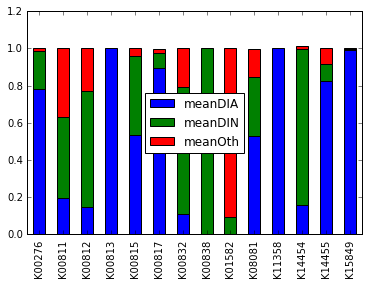

In [253]:
onePathway.plot(kind = 'bar',stacked = True)

In [280]:
#for idx2 in range(0,3):
for idx2 in range(0,len(averageAcrossAll)):
    item = trimPath[idx2]
    
    onePathway = pd.DataFrame(np.nan,index = range(0),columns = ['meanDIA','meanDIN','meanOth'])
    geneList = kegg_link('ko',item).read() #get the genes in that pathway

    for idx in range(0,len(geneList.splitlines())):
        t = geneList.splitlines()[idx] #start with the first row...
        oneK = t.split('\tko:')[1].rstrip()

        if oneK in gatherAnswers.index.tolist(): #have cases where we did not see the gene
            onePathway.loc[oneK,'meanDIA'] = gatherAnswers.loc[oneK,'meanDIA']
            onePathway.loc[oneK,'meanDIN'] = gatherAnswers.loc[oneK,'meanDIN']
            onePathway.loc[oneK,'meanOth'] = gatherAnswers.loc[oneK,'meanOth']

    averageAcrossAll.loc[item] = onePathway.mean(0)
    del onePathway

KeyboardInterrupt: 

In [279]:
averageAcrossAll

,meanDIA,meanDIN,meanOth
ko00010,0.527794,0.371247,0.102736
ko00020,0.382867,0.530656,0.0919524
ko00030,0.536356,0.37292,0.0938606
ko00040,NaN,NaN,NaN
ko00051,NaN,NaN,NaN
ko00052,NaN,NaN,NaN
ko00053,NaN,NaN,NaN
ko00061,NaN,NaN,NaN
ko00062,NaN,NaN,NaN
ko00071,NaN,NaN,NaN
